学習データを二分割し前半を使い複数のモデルを構築、後半を使い予測を行う。
得られた複数の予測を特徴として使用しメタ学習器を作成する。

In [1]:
##必要なライブラリのインポート
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
import xgboost as xgb

In [2]:
#データの読み込み
train_df = pd.read_csv(r'C:\Users\ISHIKAWA\Kaggle\Houses Prices\train.csv')
test_df = pd.read_csv(r'C:\Users\ISHIKAWA\Kaggle\Houses Prices\test.csv')

#combineを作ることで学習用データとテストデータを同時に整形する
combine = [train_df, test_df]


In [3]:
#各カラムのタイトルを確認
print(train_df.columns.values)

['Id' 'MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle'
 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF'
 '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual'
 'TotRmsAbvGrd' 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType'
 'GarageYrBlt' 'GarageFinish' 'GarageCars' 'GarageArea' 'GarageQual'
 'GarageCond' 'PavedDrive' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'PoolQC' 'Fence' 'MiscFeature'
 'MiscVal' 'MoSold' 'YrSold' 'SaleTy

In [4]:
#学習用データのデータ型、データの欠損の確認
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
#テストデータのデータ型、データの欠損の確認
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

In [6]:
#数値データの確認
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
#オブジェクトデータの確認
train_df.describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [8]:
print(train_df.shape)
print(test_df.shape)

(1460, 81)
(1459, 80)


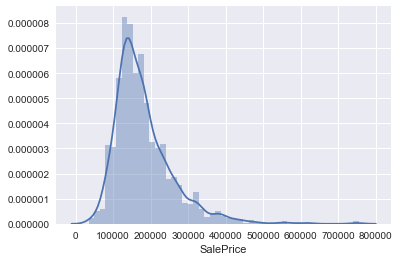

In [9]:
sns.distplot(train_df['SalePrice'])

In [10]:
train_df['SalePrice'].skew()

1.8828757597682129

In [11]:
train_df['SalePrice'].kurt()

6.5362818600645287

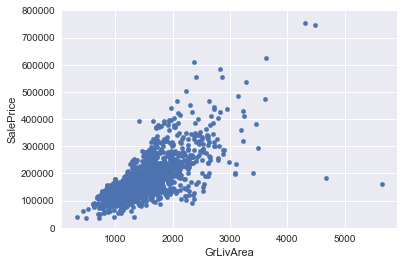

In [12]:
var = 'GrLivArea'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice', ylim = (0, 800000))

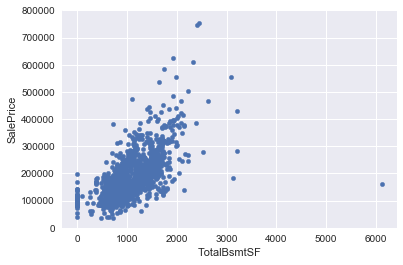

In [13]:
var = 'TotalBsmtSF'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice', ylim = (0, 800000))

C:\Users\ISHIKAWA\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


(-0.5, 9.5, 0, 800000)

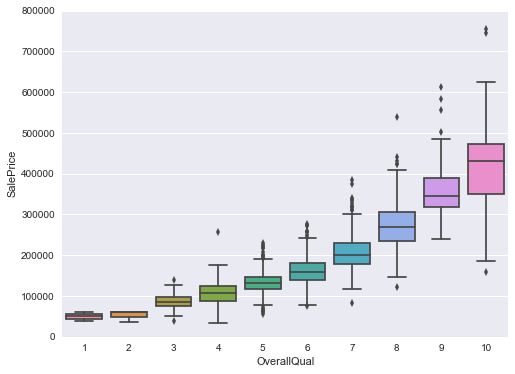

In [14]:
var = 'OverallQual'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis = 1)
f, ax = plt.subplots(figsize = (8,6))
fig = sns.boxplot(x = var, y = 'SalePrice', data = data )
fig.axis(ymin = 0, ymax = 800000)

C:\Users\ISHIKAWA\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

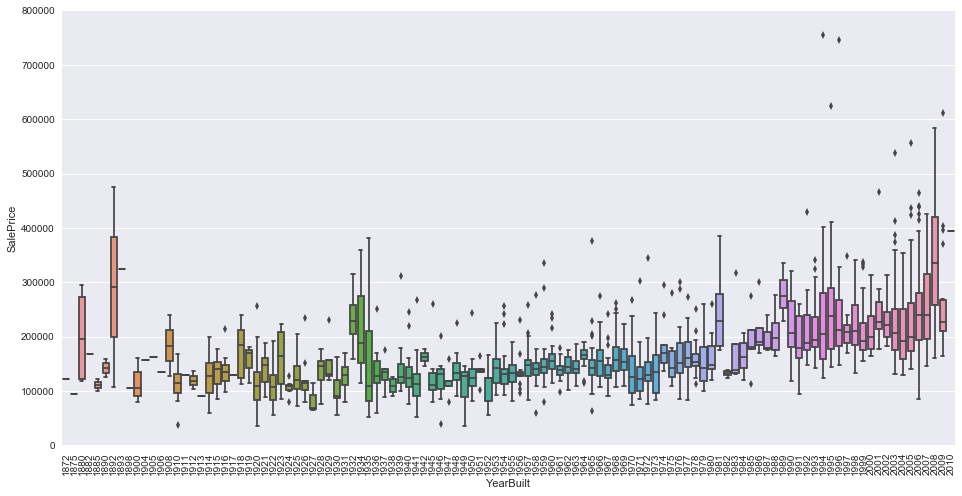

In [15]:
var = 'YearBuilt'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis = 1)
f, ax = plt.subplots(figsize = (16, 8))
fig = sns.boxplot(x = var, y = 'SalePrice', data = data )
fig.axis(ymin = 0, ymax = 800000)
plt.xticks(rotation = 90)

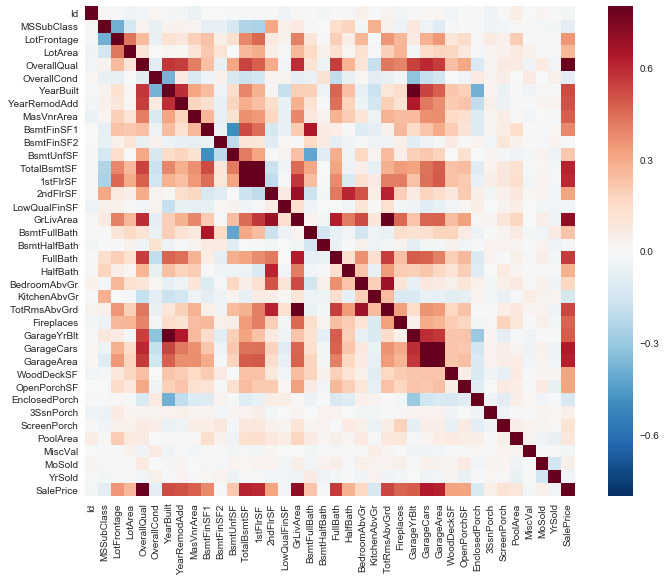

In [16]:
corrmat = train_df.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = .8, square = True)

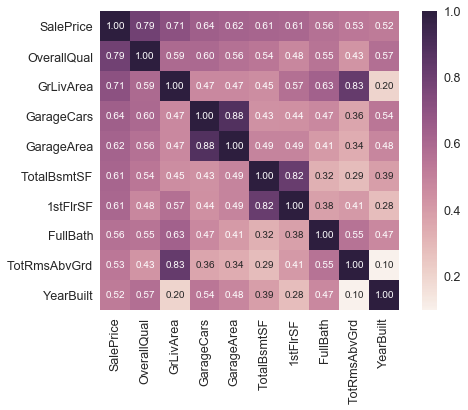

In [17]:
k =10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale =1.25)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f', annot_kws = {'size':10},\
                yticklabels = cols.values, xticklabels = cols.values)
plt.show()

In [18]:
cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')

In [19]:
#sns.set()
#cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
#sns.pairplot(train_df[cols], size = 2.5)
#plt.show()

In [20]:
all_data = pd.concat((train_df.loc[:, 'MSSubClass':'SaleCondition'],test_df.loc[:, 'MSSubClass':'SaleCondition']))

In [21]:
total = all_data.isnull().sum().sort_values(ascending = False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(40)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


In [22]:
dropf = missing_data.loc[missing_data['Total']==1].index

In [23]:
all_data.loc[all_data['Electrical'].isnull(),'Electrical'] 

1379    NaN
Name: Electrical, dtype: object

In [24]:
all_data[dropf].describe()

,BsmtFinSF2,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GarageArea,GarageCars
count,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000,2918.000000
mean,49.582248,441.423235,560.772104,1051.777587,472.874572,1.766621
std,169.205611,455.610826,439.543659,440.766258,215.394815,0.761624
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,220.000000,793.000000,320.000000,1.000000
50%,0.000000,368.500000,467.000000,989.500000,480.000000,2.000000
75%,0.000000,733.000000,805.500000,1302.000000,576.000000,2.000000
max,1526.000000,5644.000000,2336.000000,6110.000000,1488.000000,5.000000


In [25]:
all_data[dropf].describe(include='O')

,Exterior2nd,Exterior1st,SaleType,Electrical,KitchenQual
count,2918,2918,2918,2918,2918
unique,16,15,9,5,4
top,VinylSd,VinylSd,WD,SBrkr,TA
freq,1014,1025,2525,2671,1492


In [26]:
all_data['Electrical'].dtype

dtype('O')

In [27]:
all_data = all_data.drop((missing_data[missing_data['Total'] > 1]).index, 1)

In [28]:
for f in dropf:
    if all_data[f].dtype == 'O':
        all_data.loc[all_data[f].isnull(),f] = all_data[f].dropna().mode()[0]
    else:
        all_data.loc[all_data[f].isnull(),f] = all_data[f].dropna().median()
    
all_data.isnull().sum().max()

0

In [29]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [30]:
print(all_data.shape)
print(train_df.shape)
print(test_df.shape)

(2919, 56)
(1460, 81)
(1459, 80)


In [31]:
df_train = pd.concat([train_df['Id'],all_data[:train_df.shape[0]]], axis=1)
df_train = pd.concat([df_train,train_df['SalePrice']], axis=1)

In [32]:
df_test = pd.concat([test_df['Id'],all_data[train_df.shape[0]:]], axis=1)

In [33]:
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:, np.newaxis])
low_range  = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[ 3.82897043]
 [ 4.04098249]
 [ 4.49634819]
 [ 4.71041276]
 [ 4.73032076]
 [ 5.06214602]
 [ 5.42383959]
 [ 5.59185509]
 [ 7.10289909]
 [ 7.22881942]]


C:\Users\ISHIKAWA\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


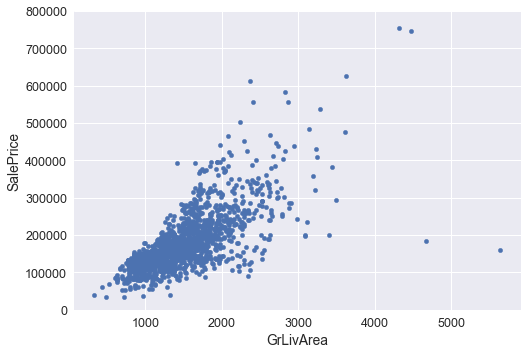

In [34]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis = 1)
data.plot.scatter(x = var, y = 'SalePrice', ylim = (0, 800000))

In [35]:
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,63887,Pave,IR3,Bnk,Corner,Gtl,Edwards,Feedr,...,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,40094,Pave,IR1,Bnk,Inside,Gtl,Edwards,PosN,...,0,0,0,0,0,10,2007,New,Partial,184750


In [36]:
df_train = df_train.drop(df_train[df_train['Id']==1299].index)
df_train = df_train.drop(df_train[df_train['Id']==524].index)

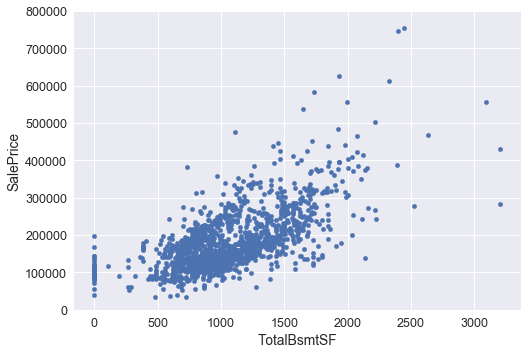

In [37]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

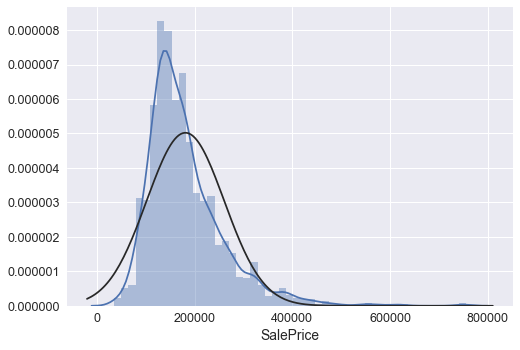

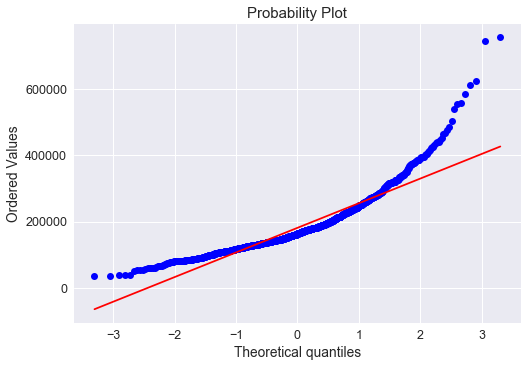

In [38]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [39]:
#applying log transformation
df_train['SalePrice'] = np.log(df_train['SalePrice'])

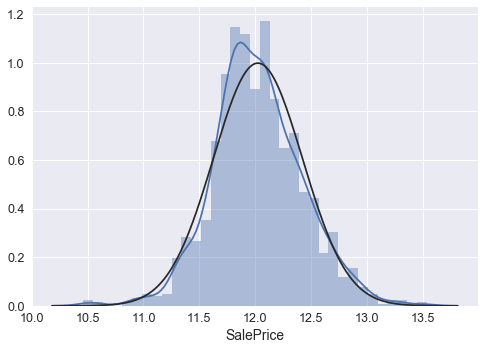

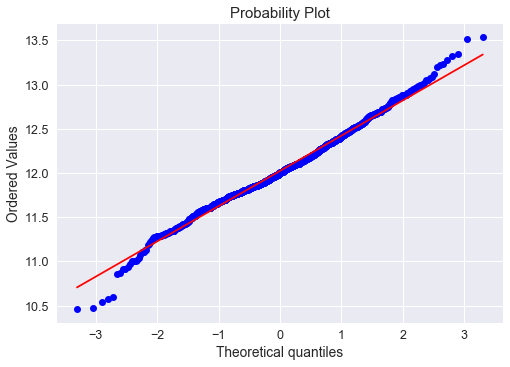

In [40]:
#transformed histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

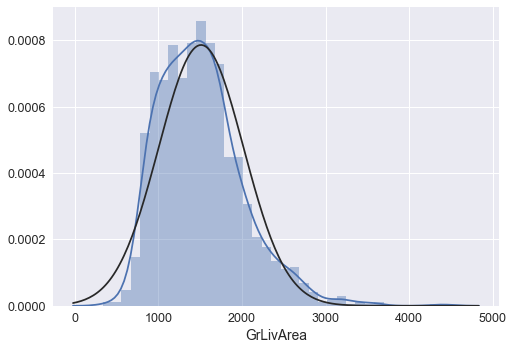

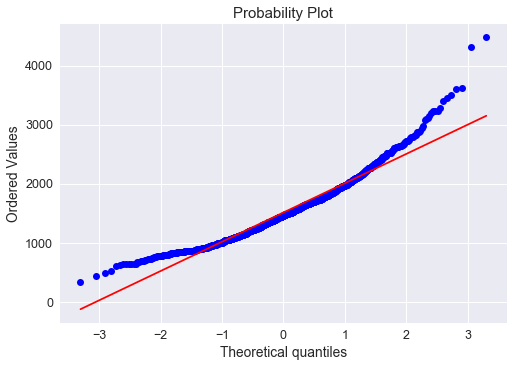

In [41]:
#histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

In [42]:
#data transformation
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])
df_test['GrLivArea'] = np.log(df_test['GrLivArea'])

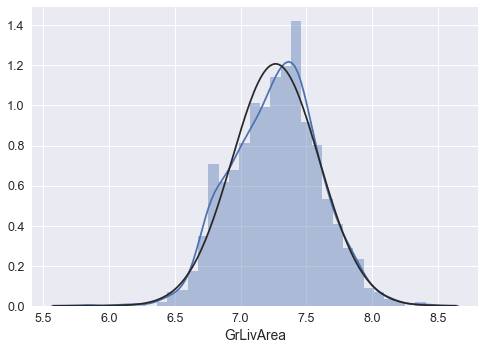

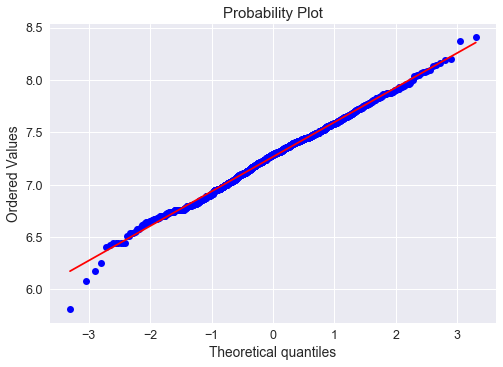

In [43]:
#transformed histogram and normal probability plot
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

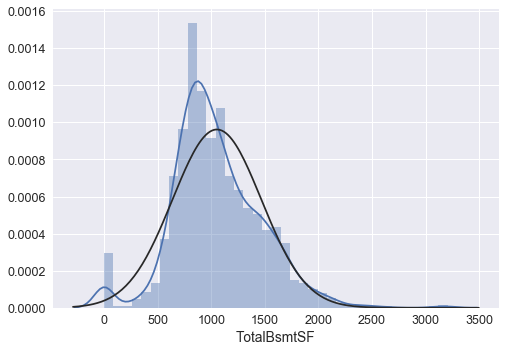

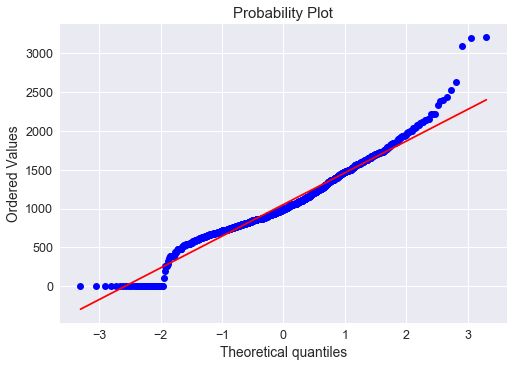

In [44]:
#histogram and normal probability plot
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)

In [45]:
df_train.head()

,Id,MSSubClass,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,...,0,0,0,0,0,2,2008,WD,Normal,12.247694
1,2,20,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,...,0,0,0,0,0,5,2007,WD,Normal,12.109011
2,3,60,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,0,0,0,0,0,9,2008,WD,Normal,12.317167
3,4,70,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,...,272,0,0,0,0,2,2006,WD,Abnorml,11.849398
4,5,60,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,...,0,0,0,0,0,12,2008,WD,Normal,12.429216


In [46]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1
df_test['HasBsmt'] = pd.Series(len(df_test['TotalBsmtSF']), index=df_test.index)
df_test['HasBsmt'] = 0 
df_test.loc[df_test['TotalBsmtSF']>0,'HasBsmt'] = 1

In [47]:
#transform data
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])
df_test.loc[df_test['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_test['TotalBsmtSF'])

C:\Users\ISHIKAWA\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\ISHIKAWA\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


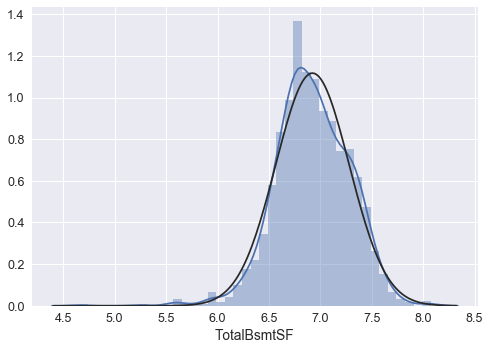

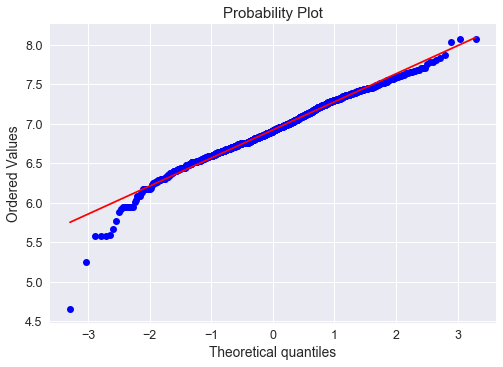

In [48]:
#histogram and normal probability plot
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

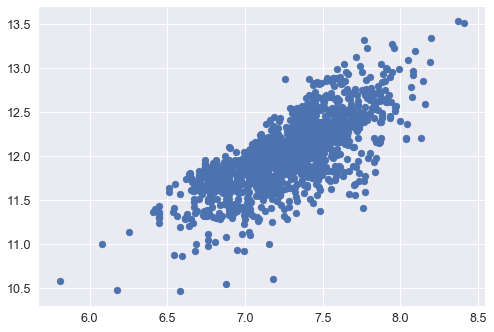

In [49]:
#scatter plot
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);

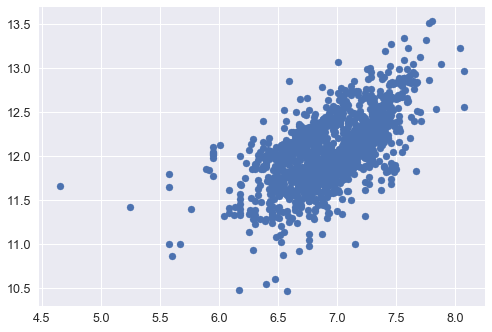

In [50]:
#scatter plot
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice']);

In [51]:
all_data = pd.concat([df_train.drop(['Id','SalePrice'], axis = 1),df_test.drop(['Id'], axis = 1)])

In [52]:
#convert categorical variable into dummy
all_data = pd.get_dummies(all_data)

In [53]:
df_train_tmp = pd.concat([df_train['Id'],all_data[:df_train.shape[0]]], axis=1)
df_train = pd.concat([df_train_tmp,df_train['SalePrice']], axis=1)

In [54]:
df_train.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1,60,8450,7,5,2003,2003,706.0,0.0,150.0,...,0,0,1,0,0,0,0,1,0,12.247694
1,2,20,9600,6,8,1976,1976,978.0,0.0,284.0,...,0,0,1,0,0,0,0,1,0,12.109011
2,3,60,11250,7,5,2001,2002,486.0,0.0,434.0,...,0,0,1,0,0,0,0,1,0,12.317167
3,4,70,9550,7,5,1915,1970,216.0,0.0,540.0,...,0,0,1,1,0,0,0,0,0,11.849398
4,5,60,14260,8,5,2000,2000,655.0,0.0,490.0,...,0,0,1,0,0,0,0,1,0,12.429216


In [55]:
df_test = pd.concat([df_test['Id'],all_data[df_train.shape[0]:]], axis=1)

In [56]:
X_train = df_train.loc[:, 'MSSubClass':'SaleCondition_Partial']
X_test = df_test.loc[:, 'MSSubClass':'SaleCondition_Partial']
y_train = df_train['SalePrice']

In [57]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet,ElasticNetCV, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [58]:
model_ridge = Ridge()

In [59]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

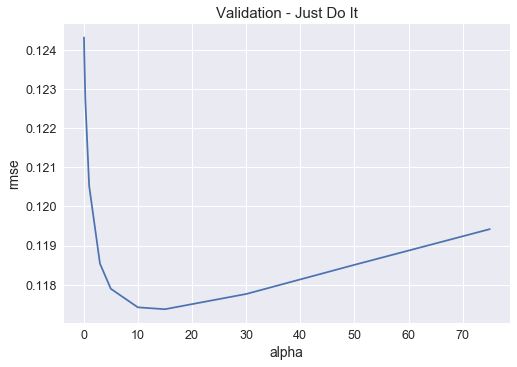

In [60]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [61]:
cv_ridge.min()

0.11737362766369008

In [62]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005, 0.000425, 0.000422, 0.000423]).fit(X_train, y_train)

In [63]:
rmse_cv(model_lasso).mean()

0.11671193898465759

In [64]:
model_lasso.alpha_

0.00042299999999999998

In [65]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [66]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 91 variables and eliminated the other 113 variables


In [67]:
dropf = coef.loc[coef==0].index
print(dropf)

Index(['HasBsmt', 'Street_Pave', 'LotShape_IR1', 'LotShape_IR3',
       'LandContour_Bnk', 'LandContour_Low', 'LandContour_Lvl',
       'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl',
       ...
       'PavedDrive_Y', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD',
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_Oth',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Partial'],
      dtype='object', length=113)


In [74]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

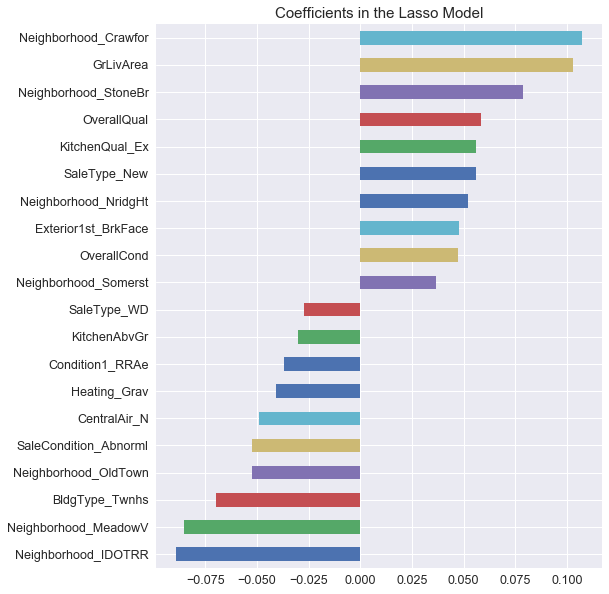

In [75]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [68]:
X_train = X_train.drop(dropf, axis = 1)
X_test = X_test.drop(dropf, axis = 1)

In [69]:
X_train.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_TA,PavedDrive_N,SaleType_COD,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal
0,60,8450,7,5,2003,2003,706.0,0.0,150.0,6.752270,...,1,0,0,0,0,0,1,0,0,1
1,20,9600,6,8,1976,1976,978.0,0.0,284.0,7.140453,...,1,0,1,0,0,0,1,0,0,1
2,60,11250,7,5,2001,2002,486.0,0.0,434.0,6.824374,...,1,0,0,0,0,0,1,0,0,1
3,70,9550,7,5,1915,1970,216.0,0.0,540.0,6.628041,...,1,0,0,0,0,0,1,1,0,0
4,60,14260,8,5,2000,2000,655.0,0.0,490.0,7.043160,...,1,0,0,0,0,0,1,0,0,1


In [70]:
X_train_columns = X_train.columns
X_test_columns = X_test.columns

In [71]:
X_train_original = X_train
X_test_original = X_test

In [72]:
#Scaling data
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [73]:
X_train = pd.DataFrame(X_train, columns = X_train_columns)
X_test = pd.DataFrame(X_test, columns = X_test_columns)
X_train.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_TA,PavedDrive_N,SaleType_COD,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Family,SaleCondition_Normal
0,0.2,-0.252743,0.5,0.0,0.663043,0.243243,0.455696,0.0,-0.559829,-0.299501,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.6,0.030822,0.0,3.0,0.076087,-0.486486,0.838256,0.0,-0.330769,0.494393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.2,0.437677,0.5,0.0,0.619565,0.216216,0.146273,0.0,-0.074359,-0.152039,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.4,0.018493,0.5,0.0,-1.250000,-0.648649,-0.233474,0.0,0.106838,-0.553569,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0
4,0.2,1.179879,1.0,0.0,0.597826,0.162162,0.383966,0.0,0.021368,0.295414,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
X_train.loc[:728,:].shape

(729, 91)

In [87]:
X_train.loc[729:,:].shape

(729, 91)

In [95]:
print(y_train.loc[:729].shape)
print(y_train.loc[730:].shape)

(729,)
(729,)


In [76]:
from sklearn.model_selection import KFold

#kf = KFold(n_splits=3)
#index_1,index_2,index_3=kf.split(X_train, y_train)

In [99]:
X_train_1 = X_train.loc[:728,:]
X_train_2 = X_train.loc[729:,:]

y_train_1 = y_train.loc[:729]
y_train_2 = y_train.loc[730:]


In [100]:
model_enet = ElasticNetCV(l1_ratio = [0.1*i for i in range(10)], alphas = [1, 0.1, 0.0005, 0.00045, 0.0006 ],\
                         max_iter = 10*3).fit(X_train_1, y_train_1)
print(model_enet.l1_ratio_)
print(model_enet.alpha_)
print(rmse_cv(model_enet).mean())

C:\Users\ISHIKAWA\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\ISHIKAWA\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\ISHIKAWA\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\ISHIKAWA\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positi

0.9
0.0006


C:\Users\ISHIKAWA\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\ISHIKAWA\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\ISHIKAWA\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\ISHIKAWA\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with ver

0.114821129529


C:\Users\ISHIKAWA\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [119]:
y_train_2_pred_1 = model_enet.predict(X_train_2)
y_test_pred_1 = model_enet.predict(X_test)

In [102]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_1)
X_train_1_sc = scaler.transform(X_train_1)
X_train_2_sc = scaler.transform(X_train_2)
X_test_sc = scaler.transform(X_test)

In [103]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

C = [10**i for i in range(0,3)]
epsilon = [10**i for i in range(-4,-1)]
gamma = [10**i for i in range(-5,-2)]

tuned_parameters = {'C':C, 'epsilon':epsilon, 'gamma':gamma}

svr = RandomizedSearchCV(
    SVR(), # 識別器
    tuned_parameters, # 最適化したいパラメータセット
    n_iter = 20, 
    n_jobs = 4,
    cv=4, # 交差検定の回数
    scoring='neg_mean_squared_error') # モデルの評価関数の指定


svr.fit(X_train_1_sc, y_train_1)
print(np.sqrt(-svr.best_score_))
print(svr.best_params_)

0.124273447636
{'gamma': 0.001, 'epsilon': 0.0001, 'C': 1}


In [104]:
model_svr = SVR(C=1, epsilon=0.0001, gamma=0.001)
model_svr.fit(X_train_1_sc, y_train_1)
#rmse_cv(model_svr).mean()

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.0001, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [118]:
y_train_2_pred_2 = model_svr.predict(X_train_2_sc)
y_test_pred_2 = model_svr.predict(X_test_sc)

In [106]:
eta = [0.03, 0.1, 0.3, 1,]
subsample = [0.2,0.4,0.6,0.8,1]
colsample_bytree = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
max_depth = [2,3,4,5,6,7,8,9,10]
l2_lambda = [0.01,0.03,0.1,0.3,1,3,10]
n_estimators = [100, 200, 300, 400, 500]

tuned_parameters = {'learning_rate':eta, 'subsample':subsample, 'n_estimators':n_estimators,\
                        'colsample_bytree':colsample_bytree, 'reg_lambda':l2_lambda, 'max_depth':max_depth}

xgbm = RandomizedSearchCV(
    xgb.XGBRegressor(), # 識別器
    tuned_parameters, # 最適化したいパラメータセット
    n_iter = 20, 
    n_jobs = 4,
    cv=5, # 交差検定の回数
    scoring='neg_mean_squared_error') # モデルの評価関数の指定


xgbm.fit(X_train_1, y_train_1)
print(np.sqrt(-xgbm.best_score_))
print(xgbm.best_params_)

0.132691567169
{'subsample': 0.4, 'reg_lambda': 0.03, 'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.5}


In [107]:
model_xgb = xgb.XGBRegressor(n_estimators=200, max_depth=2, learning_rate=0.1,\
                             reg_lambda=0.03, colsample_bytree=0.5, subsample=0.4) #the params were tuned using xgb.cv
model_xgb.fit(X_train_1, y_train_1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=0.03, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.4)

In [108]:
rmse_cv(model_xgb).mean()

0.12449161587545254

In [117]:
y_train_2_pred_3 = model_xgb.predict(X_train_2)
y_test_pred_3 = model_xgb.predict(X_test)

In [120]:
columns_nm = ['Enet', 'SVR', 'XGB'] 

y_train_2_pred_1 = pd.Series(y_train_2_pred_1)
y_train_2_pred_2 = pd.Series(y_train_2_pred_2)
y_train_2_pred_3 = pd.Series(y_train_2_pred_3)
y_train_pred = pd.concat([y_train_2_pred_1,y_train_2_pred_2,y_train_2_pred_3], axis=1)
y_train_pred.shape

(729, 3)

In [121]:
y_train_pred.columns = columns_nm
y_train_pred.head()

,Enet,SVR,XGB
0,12.442079,12.446604,12.486581
1,12.126151,12.117406,12.151879
2,12.330855,12.328706,12.364440
3,11.799250,11.779678,11.850202
4,11.545851,11.643524,11.527210


In [122]:
y_test_pred_1 = pd.Series(y_test_pred_1)
y_test_pred_2 = pd.Series(y_test_pred_2)
y_test_pred_3 = pd.Series(y_test_pred_3)
y_test_pred = pd.concat([y_test_pred_1,y_test_pred_2,y_test_pred_3], axis=1)

y_test_pred.columns = columns_nm

In [128]:
X_train_stg1 = y_train_pred
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005, 0.000425, 0.00045, 0.00047]).fit(X_train_stg1, y_train_2)
model_lasso.alpha_

0.00042499999999999998

In [129]:
model_lasso.coef_

array([ 0.37714182,  0.36287493,  0.28466626])

In [130]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train_2, model_lasso.predict(X_train_stg1))

0.011722389969527363

In [133]:
preds = np.exp(model_lasso.predict(y_test_pred))

In [134]:
solution = pd.DataFrame({"id":df_test['Id'], "SalePrice":preds})
solution.to_csv("submission_25.csv", index = False)